# Assignment ESM Module - Renewable Energy Droughts


# Table of contents 

1. [Exercise 1 - ERA5 Download and Merge](#ex1)
3. [Exercise 2](#ex2)
    1. [Solar capacity factor](#ex2a)
    2. [Wind Speed](#ex2b)
    3. [Wind capacity factor](#ex2c)
5. [Exercise 3: Plotting capacity factors for NUTS-1 regions](#ex3)
6. [Exercise 4](#ex4)
    1. [Step 1](#ex4-1)
    2. [Step 2](#ex4-1)
    3. [Step 3](#ex4-3)
7. [Exercise 5 - Modelling RES droughts](#ex5)
8. [Exercise 6](#ex6)
9. [Sources](#sources)

## Exercise 1 - ERA5 data download and merge  <a id="ex1"></a>

We start by importing the given datasets. 

In [3]:
import xarray as xr 

ds1 = xr.open_dataset("data/SSRD_data_stream-oper_stepType-accum.nc", engine="netcdf4")

ds2 = xr.open_dataset(
    "data/Wind_T_data_stream-oper_stepType-instant(1).nc", engine="netcdf4"
)


getfattr: Removing leading '/' from absolute path names
sh: -c: line 1: syntax error near unexpected token `('
sh: -c: line 1: `getfattr /home/victor/dev/dafs/final_assignment/data/Wind_T_data_stream-oper_stepType-instant(1).nc | grep -c '.daos''


In [4]:
# set coordinates box of region of interest: 
north = 71.22
south = 34.31
east = 51.29
west = -23.62

Next, we download the dataset from the [Copernicus Database](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download), (see [docs](https://confluence.ecmwf.int/)) and we generate the following API call:



In [5]:
reimport_flag = False  # Set to True to reimport 

if reimport_flag:
    import cdsapi

    dataset = "reanalysis-era5-single-levels"
    request = {
        "product_type": ["reanalysis"],
        "variable": [
            "2m_temperature",
            "100m_u_component_of_wind",
            "100m_v_component_of_wind",
            "surface_solar_radiation_downwards",
        ],
        "year": ["2022"],
        "month": ["01", "02", "03", "04", "05", "06"],
        "day": [
            "01",
            "02",
            "03",
            "04",
            "05",
            "06",
            "07",
            "08",
            "09",
            "10",
            "11",
            "12",
            "13",
            "14",
            "15",
            "16",
            "17",
            "18",
            "19",
            "20",
            "21",
            "22",
            "23",
            "24",
            "25",
            "26",
            "27",
            "28",
            "29",
            "30",
            "31",
        ],
        "time": [
            "00:00",
            "03:00",
            "06:00",
            "09:00",
            "12:00",
            "15:00",
            "18:00",
            "21:00",
        ],
        "data_format": "netcdf",
        "download_format": "zip",
        "area": [north, west, south, east],
    }

    client = cdsapi.Client()
    client.retrieve(dataset, request).download()

We unzip the file into the /data directory, then import them using xarray

In [6]:
file1 = "data/data_stream-oper_stepType-accum.nc"
file2 = "data/data_stream-oper_stepType-instant.nc"

ds3 = xr.open_dataset(
    file1,
    engine="netcdf4",
)

ds4 = xr.open_dataset(
    file2,
    engine="netcdf4",
)

We merge them so that we have data for the entire year 2022

In [7]:
ds_h1 = xr.merge([ds3, ds4], join="outer", compat="identical")
ds_h2 = xr.merge([ds1, ds2], join="outer", compat="identical")
era5 = xr.concat([ds_h1, ds_h2], dim="valid_time")

Next we can see a few of the dataframe's attributes using dataframe.info():

In [8]:
era5.info()

xarray.Dataset {
dimensions:
	valid_time = 2920 ;
	latitude = 148 ;
	longitude = 300 ;

variables:
	float32 ssrd(valid_time, latitude, longitude) ;
		ssrd:GRIB_paramId = 169 ;
		ssrd:GRIB_dataType = fc ;
		ssrd:GRIB_numberOfPoints = 44400 ;
		ssrd:GRIB_typeOfLevel = surface ;
		ssrd:GRIB_stepUnits = 1 ;
		ssrd:GRIB_stepType = accum ;
		ssrd:GRIB_gridType = regular_ll ;
		ssrd:GRIB_uvRelativeToGrid = 0 ;
		ssrd:GRIB_NV = 0 ;
		ssrd:GRIB_Nx = 300 ;
		ssrd:GRIB_Ny = 148 ;
		ssrd:GRIB_cfName = surface_downwelling_shortwave_flux_in_air ;
		ssrd:GRIB_cfVarName = ssrd ;
		ssrd:GRIB_gridDefinitionDescription = Latitude/Longitude Grid ;
		ssrd:GRIB_iDirectionIncrementInDegrees = 0.25 ;
		ssrd:GRIB_iScansNegatively = 0 ;
		ssrd:GRIB_jDirectionIncrementInDegrees = 0.25 ;
		ssrd:GRIB_jPointsAreConsecutive = 0 ;
		ssrd:GRIB_jScansPositively = 0 ;
		ssrd:GRIB_latitudeOfFirstGridPointInDegrees = 71.06 ;
		ssrd:GRIB_latitudeOfLastGridPointInDegrees = 34.31 ;
		ssrd:GRIB_longitudeOfFirstGridPointInDegr

## Exercise 2 - Determining solar and wind power capacity factors <a id="ex2"></a>

### Solar capacity factor <a id="ex2a"></a>

In [9]:
import numpy as np

def calculate_pv_cf(data):
    ghi_wh = data["ssrd"] / 3600
    Tmod = (data["t2m"] - 273.15) + (28 * (ghi_wh / 800))
    deltaTmod = Tmod - (25)
    G_tilde = ghi_wh / 1000

    nrel = (1 + (0.0012 * deltaTmod)) * (
        1
        + (0.033 * np.log(G_tilde))
        + (-0.0092 * (np.log(G_tilde) ** 2))
        + (-0.0046 * deltaTmod)
    )
    pv_cf = nrel * (ghi_wh / 1000)
    pv_cf = pv_cf.fillna(0)
    return pv_cf

In [10]:
era5["cf_pv"] = calculate_pv_cf(era5)

# note the divide by zero error below is not an issue because we are multiplying the result by gwhi = 0, yielding zero

/home/victor/.conda/envs/energy_research/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


Below we have plotted the mean ssrd and solar capacity factor in europe. They look very similar, which is to be expected

Text(0.5, 1.0, 'Average Surface Radiation, Europe 2022')

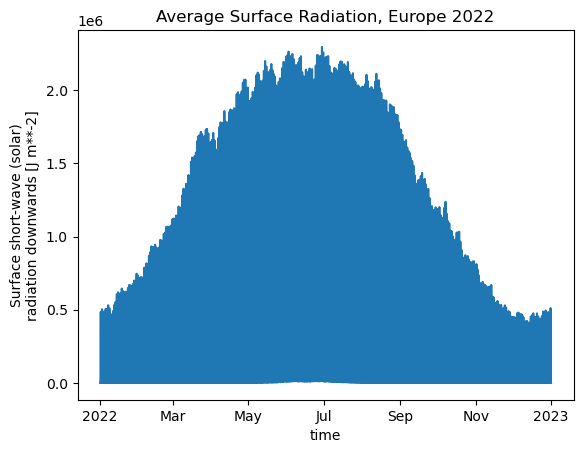

In [11]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
era5["ssrd"].mean(dim=['latitude', 'longitude']).plot()
ax.set_title("Average Surface Radiation, Europe 2022")

Text(0.5, 1.0, 'Average Solar Capacity Factor, Europe 2022')

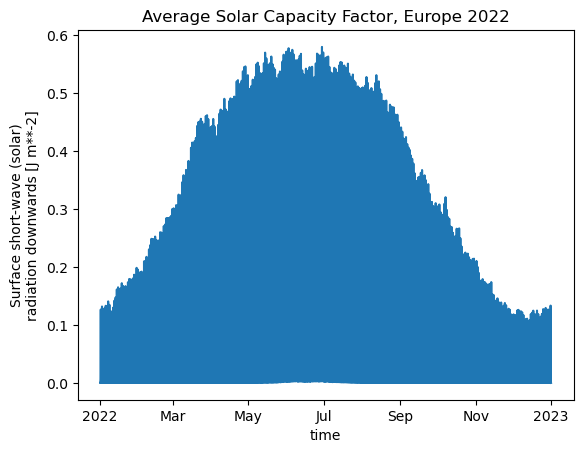

In [12]:
# let's map out cf_pv
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()

era5['cf_pv'].mean(dim=['latitude','longitude']).plot()

ax.set_title("Average Solar Capacity Factor, Europe 2022")

### Wind Speeds <a id="ex2c"></a>

In [13]:
# we calculate the wind speed using the pythagorean theorem
import numpy as np
era5['ws'] = np.sqrt(era5['u100'] **2 + era5['v100']** 2)

We find what looks like a weibull distribution: 

(array([2.2777870e+06, 6.2769100e+06, 8.7513650e+06, 1.0001648e+07,
        1.0826402e+07, 1.1421318e+07, 1.1558272e+07, 1.0981941e+07,
        9.8316620e+06, 8.4621390e+06, 7.1124830e+06, 5.9412680e+06,
        4.9341120e+06, 4.1058730e+06, 3.4195630e+06, 2.8145780e+06,
        2.3001280e+06, 1.8673030e+06, 1.5092540e+06, 1.2034280e+06,
        9.6348100e+05, 7.6514800e+05, 5.9137900e+05, 4.5527800e+05,
        3.5002900e+05, 2.6727600e+05, 2.0027800e+05, 1.4374400e+05,
        1.0300600e+05, 6.9558000e+04, 4.5127000e+04, 3.0774000e+04,
        2.1199000e+04, 1.3953000e+04, 9.8410000e+03, 7.1460000e+03,
        4.9870000e+03, 3.1700000e+03, 2.1100000e+03, 1.3420000e+03,
        7.4800000e+02, 4.0500000e+02, 2.4400000e+02, 1.2100000e+02,
        7.8000000e+01, 5.2000000e+01, 3.3000000e+01, 2.9000000e+01,
        1.7000000e+01, 1.3000000e+01]),
 array([3.88375018e-04, 8.72874141e-01, 1.74535990e+00, 2.61784577e+00,
        3.49033141e+00, 4.36281681e+00, 5.23530293e+00, 6.10778856e+00,


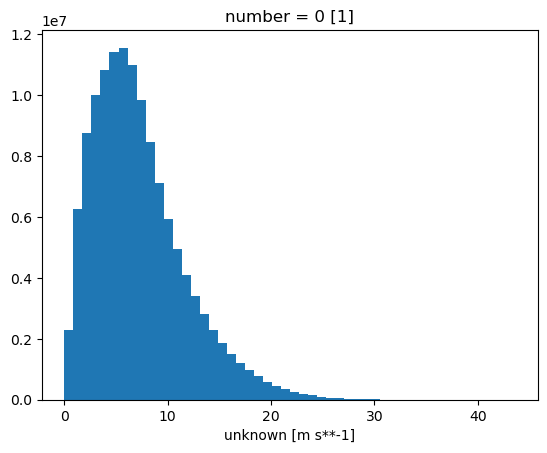

In [14]:
era5['ws'].plot(bins=50)

### Wind capacity factor

We use the following power curve :
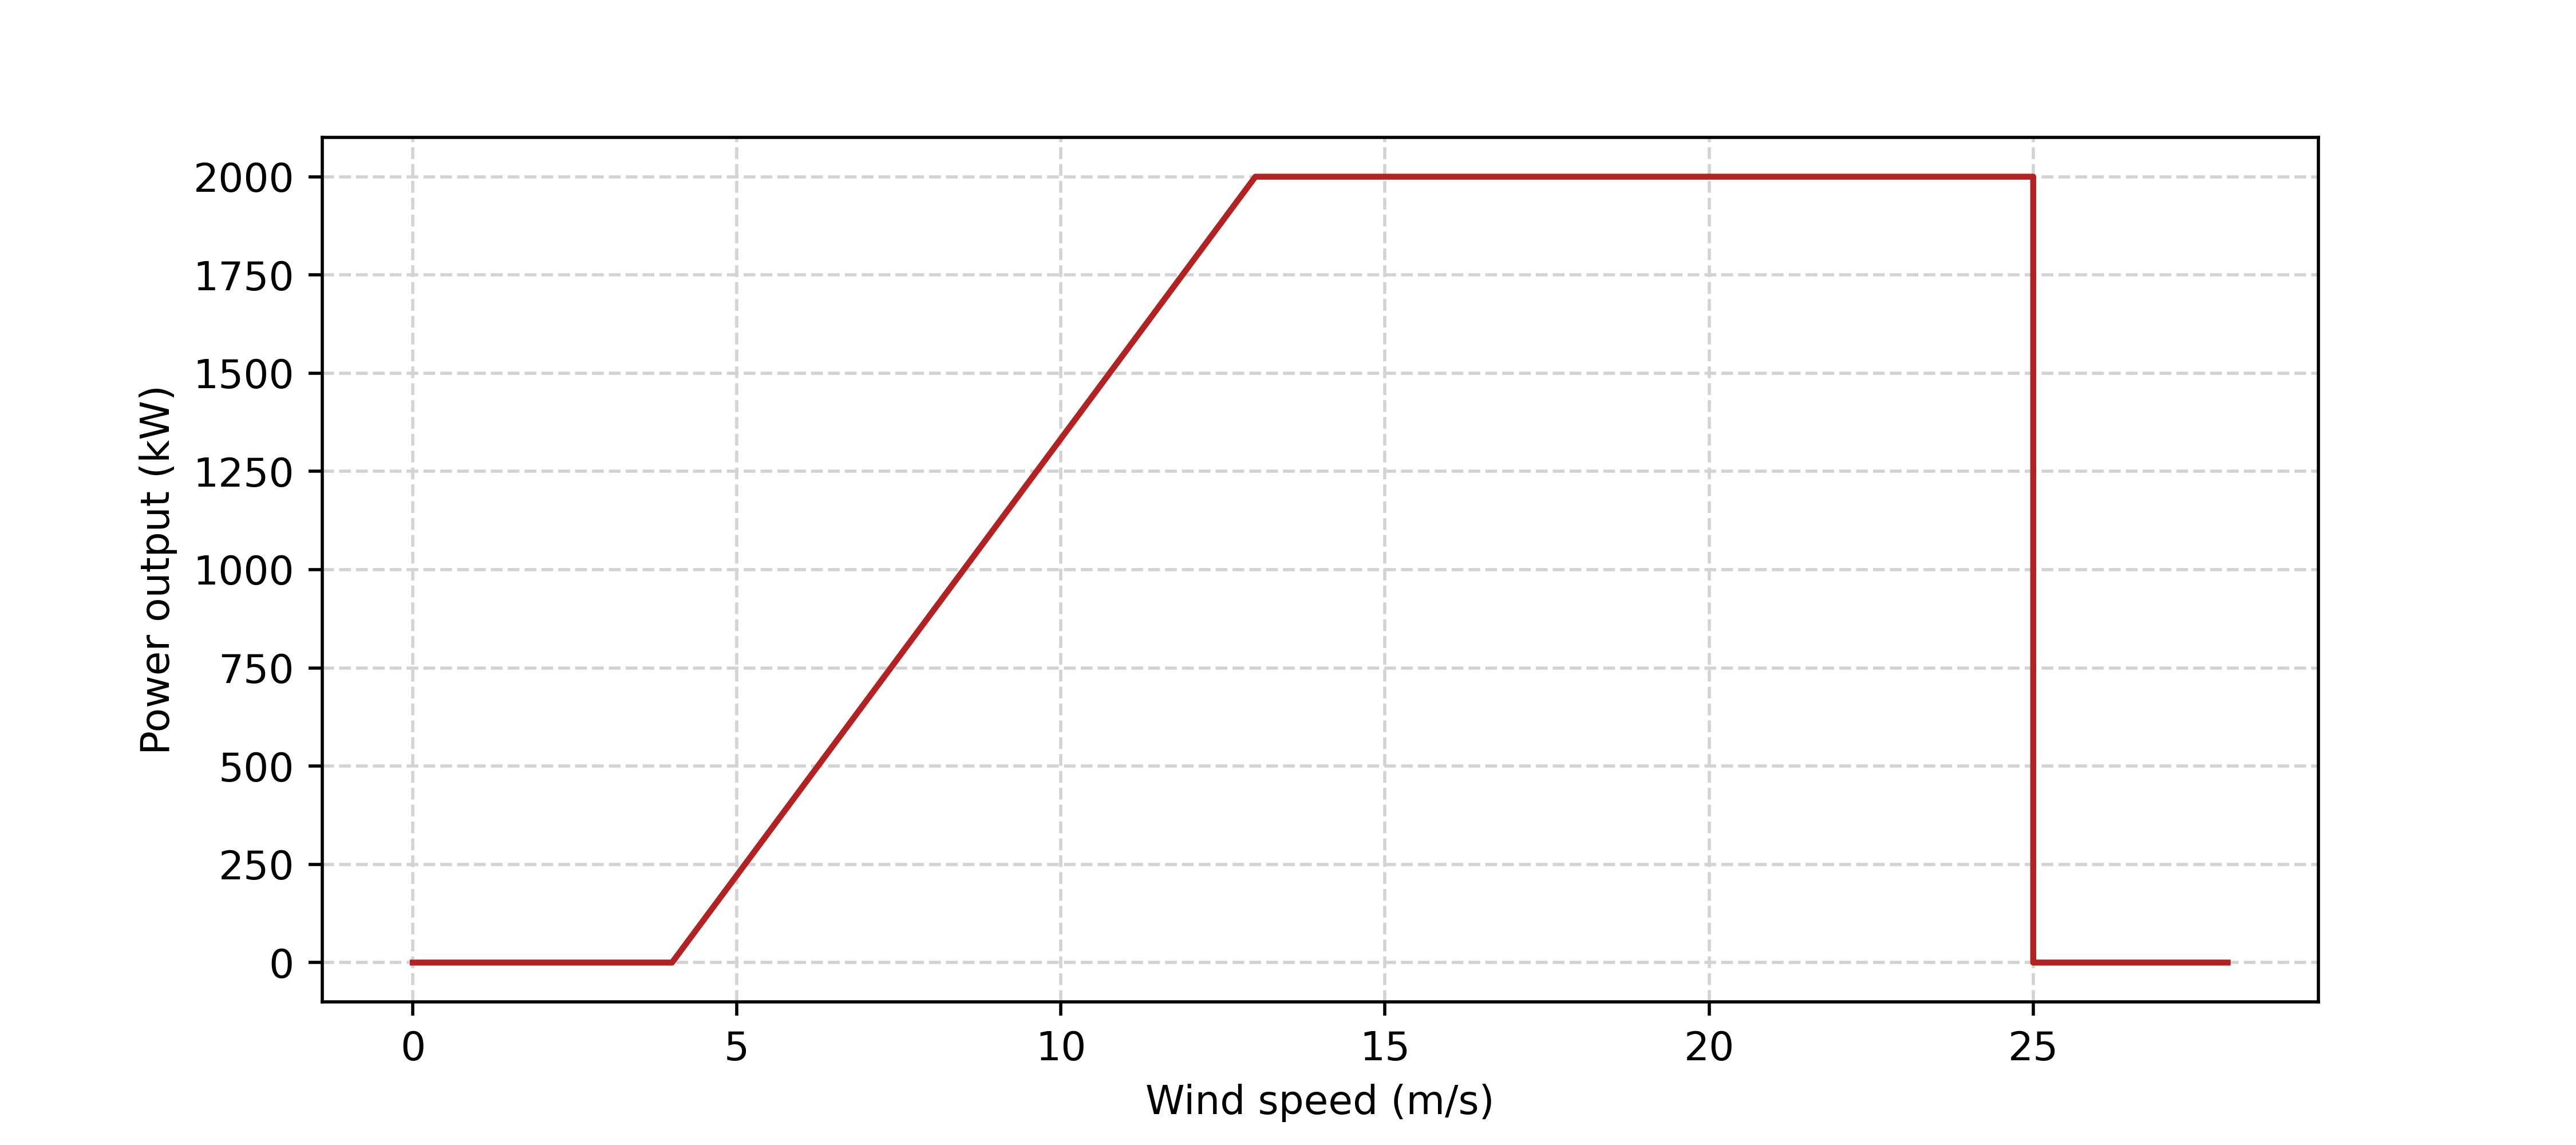



By analysing the graph and plugging in some values, we come to the conclusion that we have a piecewise function:  

$$
\begin{aligned}
P(v) = \begin{cases}
 0 & \text{v < 4} \\
\frac{2000}{9} v - \frac{8000}{9} & \text{ 4 < v < 13 } \\
2000 & \text{13 < v < 25 } \\
0 & \text{v > 20} 
\end{cases}
\end{aligned}
$$


We define a function `calculate_power` that implements the above piecewise function in python. We then divide the output power by the rated power to get a capacity factor

In [15]:

import math

def calculate_power(data):
    wind_speed = data["ws"] 
    cut_in = 4
    cut_off = 25
    rated_power = 2000.0
    min_rated_wind_speed = 13
    mask_linear_region = ((wind_speed > cut_in) & (wind_speed < min_rated_wind_speed))
    mask_rated_region =( (wind_speed >= min_rated_wind_speed) & (wind_speed < cut_off))
    power_linear = xr.where(mask_linear_region, 2000/9 * wind_speed - 8000/9, 0) 
    power_rated = xr.where(mask_rated_region, 2000, 0) 
    return power_linear + power_rated 
   

def calculate_cfactor_wind(data:xr.DataArray ) -> xr.DataArray:
    rated_power = 2000.0
    return calculate_power(data) / rated_power


def wind_speed(u100, v100):
    return math.sqrt(u100 * u100 + v100 * v100)



We now apply this function to create a new array:

In [16]:
era5["cf_wind"] = calculate_cfactor_wind(era5)  

### Sanity Check

How do we verify that this is correct? Well, we have a bunch of points for wind speed and a bunch of points for wind capacity factor, so we can just produce a scatter plot of one against the other. We will choose a single latitude and use data points over a year. 

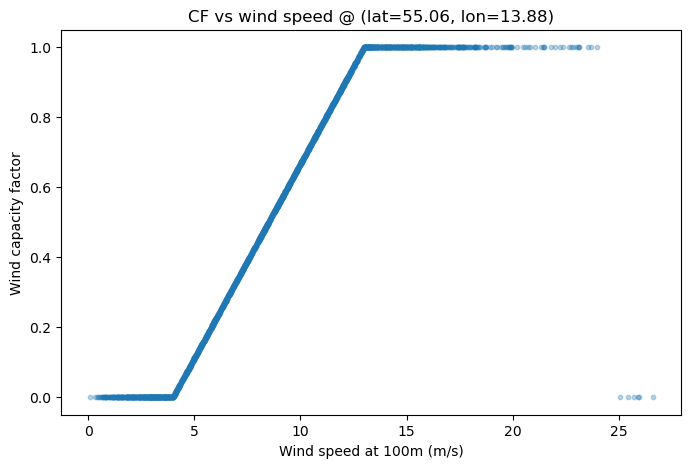

In [17]:
import matplotlib.pyplot as plt


pt = era5.sel(latitude=55, longitude=14, method="nearest")

ws = pt["ws"]
cf = pt["cf_wind"]

plt.figure(figsize=(8,5))
plt.scatter(ws.values, cf.values, s=10, alpha=0.3)
plt.xlabel("Wind speed at 100m (m/s)")
plt.ylabel("Wind capacity factor")
plt.title(f"CF vs wind speed @ (lat={float(pt.latitude.values):.2f}, lon={float(pt.longitude.values):.2f})")
plt.ylim(-0.05, 1.05)
plt.show()


In [18]:
era5["cf_wind"].shape  # (valid_time, lat, long)

(2920, 148, 300)

Text(0.5, 1.0, 'time-averaged wind capacity factor (2022)')

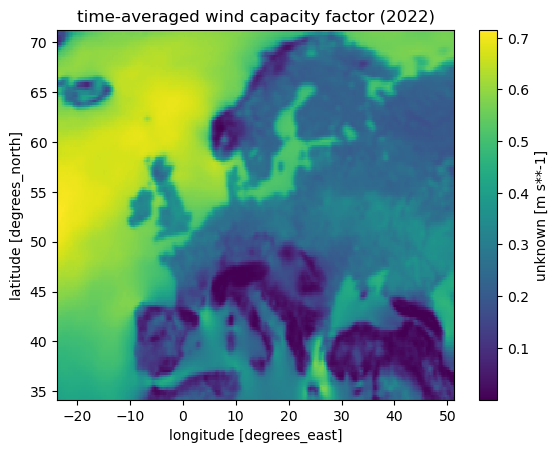

In [19]:
# let's map cf_pv


(fig, ax) = plt.subplots()

era5.mean(dim="valid_time")["cf_wind"].plot()

ax.set_title("time-averaged wind capacity factor (2022)")

## Exercise 3 - Plotting capacity factors for NUTS-1 regions <a id="ex3"></a>

We start by importing the NUTS-1 database which we looked at in week 5.  

In [20]:
# import database with NUTS regions:
import geopandas as gpd
from pathlib import Path

gdf = gpd.read_file(Path("../week5/data/NUTS_RG_10M_2024_4326.geojson"))

gdf.set_index('NUTS_ID', inplace=True)

Dropping NUTS-2 and NUTS-3

In [21]:
mask_nuts1 = gdf["LEVL_CODE"] == 1
gdf_nuts1 = gdf[mask_nuts1]

We note that due to overseas territories, the NUTS data encompasses a greater geographical range than the ERA5 data, as we can see below:

Text(0.5, 1.0, 'NUTS Level 1 regions in europe')

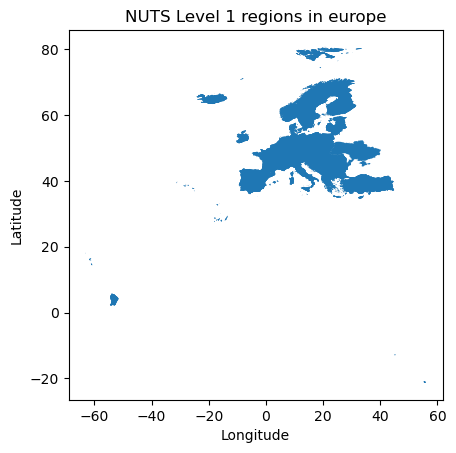

In [22]:
# Exploratory data analysis


(fig, ax) = plt.subplots()
gdf.plot(ax=ax, linewidth=0.1)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_title("NUTS Level 1 regions in europe")

In [23]:
if not hasattr(era5, "crs"):
    era5.rio.write_crs("EPSG:4326", inplace=True)

In [24]:
era5.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

Text(0.5, 1.0, 'NUTS1 extent with smaller ERA5 coverage')

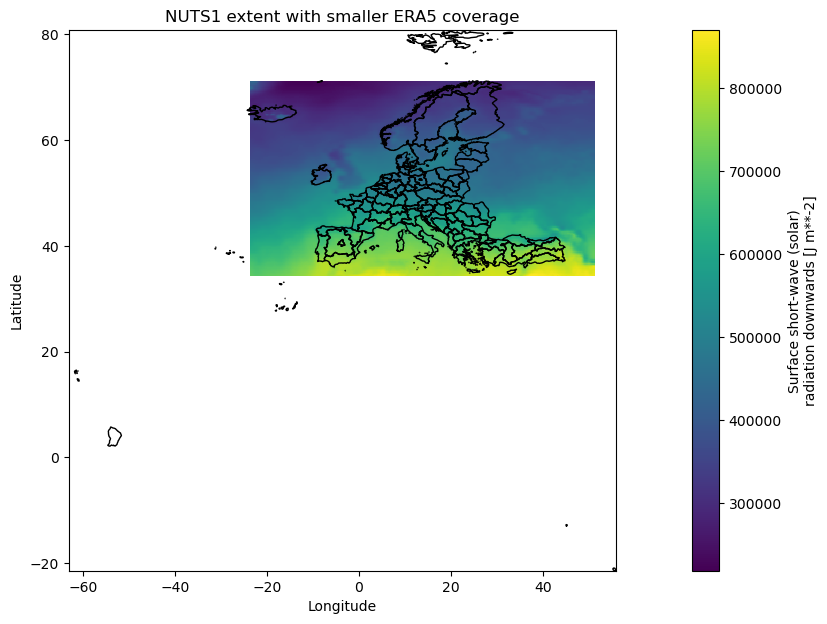

In [25]:
fig, ax = plt.subplots(1, figsize=(16, 6))
plt.tight_layout()

# 1) Plot NUTS1 first (this defines the "true" spatial extent)
gdf_nuts1.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1, zorder=3)

# Save NUTS extent
xmin, ymin, xmax, ymax = gdf_nuts1.total_bounds

# 2) Plot ERA5 (smaller spatial coverage)
era5["ssrd"].mean(dim="valid_time").plot(ax=ax, alpha=1, zorder=1)

# 3) Restore the larger extent
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("NUTS1 extent with smaller ERA5 coverage")

In [26]:
f"There are {len(gdf_nuts1)} NUTS 1 regions"

'There are 115 NUTS 1 regions'

So we need to clip the ERA5 data to match the NUTS data

In [27]:
from shapely.geometry import box


area = box(west, south, east, north)

gdf_nuts1 = gdf_nuts1.clip(area)

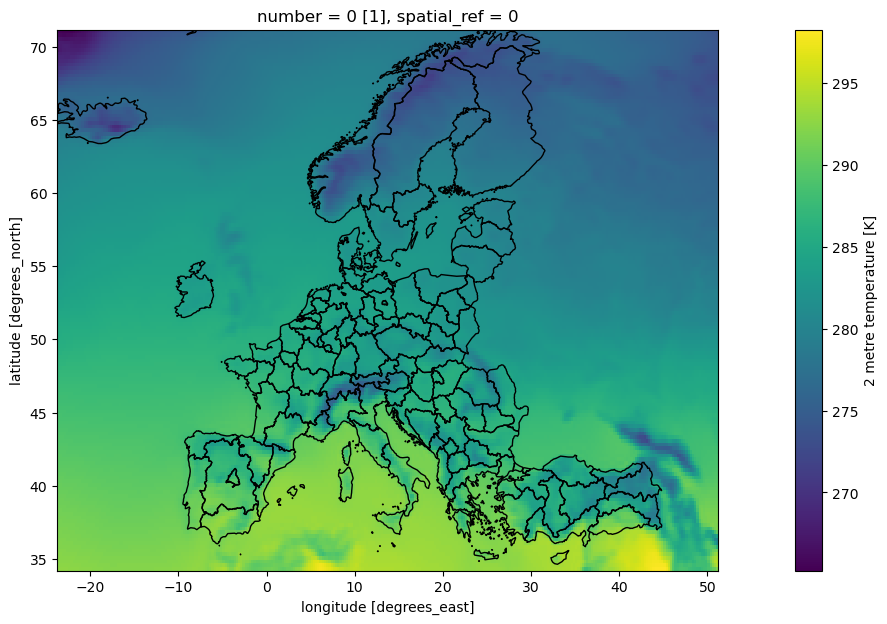

In [28]:
fig, ax = plt.subplots(1, figsize=(16, 6))
plt.tight_layout()

# Plot boundaries first
gdf_nuts1.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1, zorder=2)

# Plot raster on top (or underneath) with transparency
era5["t2m"].mean(dim="valid_time").plot(ax=ax, alpha=1, zorder=1)

In [29]:
print(f"the clipped version has {len(gdf_nuts1)} regions")

the clipped version has 111 regions


We save 111 clipped nc files to our local directory, importing them for them to be used in 

In [30]:
# check that the directory contains all NUTS 1 regions


def must_reclip():
    """
    return true if clipped_era5/ doesn't contain all the files
    """
    return not set(
        map(
            lambda x: x.removeprefix("net_cdf_file_").removesuffix(".nc"),
            os.listdir("./data/clipped_era5"),
        )
    ) == set(gdf_nuts1.index)

In [31]:
from shapely.geometry import mapping
import os


if must_reclip():
    # note: this takes several minutes
    if not os.path.isdir("data/clipped_era5/"):
        os.mkdir("data/clipped_era5")
    for num, region_id in enumerate(gdf_nuts1.index):
        region = gdf_nuts1.loc[[region_id]].copy()
        print(num, region_id)
        clipped_era5 = era5.rio.clip(
            region.geometry.apply(mapping), drop=True, all_touched=True
        )
        # write to file?

        clipped_era5.to_netcdf(f"./data/clipped_era5/net_cdf_file_{region_id}.nc")

In [32]:
# calculate mean cf per region:

for id in gdf_nuts1.index:
    ds1 = xr.open_dataset(f"./data/clipped_era5/net_cdf_file_{id}.nc", engine="netcdf4")
    cf_pv_mean = ds1["cf_pv"].mean(dim=["valid_time", "latitude", "longitude"]).item()
    cf_wind_mean = (
        ds1["cf_wind"].mean(dim=["valid_time", "latitude", "longitude"]).item()
    )
    gdf_nuts1.loc[id, "cf_pv"] = cf_pv_mean
    gdf_nuts1.loc[id, "cf_wind"] = cf_wind_mean

getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute pat

In [33]:
# note that we now have a df with both cfs:

gdf_nuts1[["cf_pv", "cf_wind"]]

f'The max cf_wind is {gdf_nuts1["cf_wind"].max():.2f}'

'The max cf_wind is 0.49'

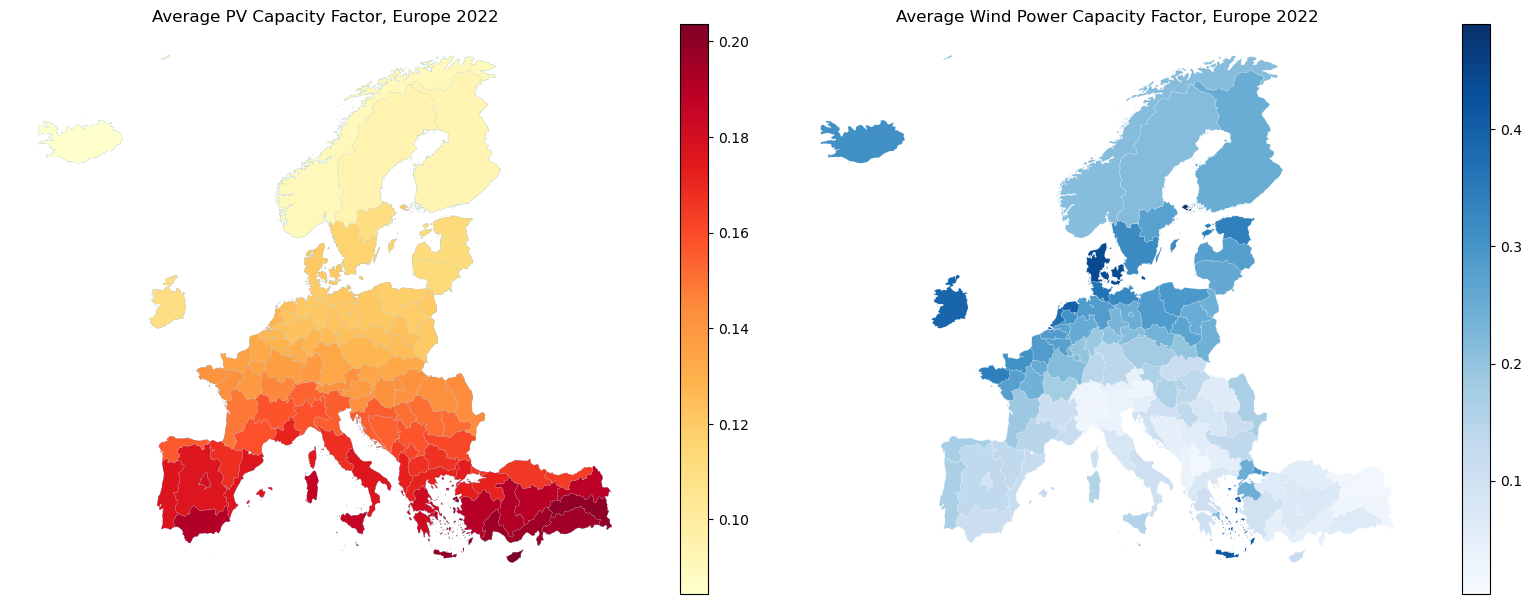

In [34]:
# insert your code for plotting the capacity factor maps here

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

gdf_nuts1.plot(ax=ax1)

# CF layer (filled choropleth)
gdf_nuts1.plot(
    ax=ax1,
    column="cf_pv",
    legend=True,
    edgecolor="white",
    linewidth=0.1,
    label="PV Capacity Factor",
    cmap="YlOrRd",
)


# CF layer (filled choropleth)
gdf_nuts1.plot(
    ax=ax2,
    column="cf_wind",
    legend=True,
    edgecolor="white",
    linewidth=0.1,
    cmap="Blues",
)

ax1.set_title("Average PV Capacity Factor, Europe 2022")

ax2.set_title("Average Wind Power Capacity Factor, Europe 2022")

ax1.set_axis_off()
ax2.set_axis_off()


plt.tight_layout()
fig.savefig("mean_cfs", bbox_inches="tight")

We can see that wind and solar are somewhat complementary. Northerly regions have better wind capacity and southern regions have better solar capacity. 

### Sanity Check: Denmark 

The average national capacity factor for denmark [is reported](https://usercontent.one/wp/iea-wind.org/wp-content/uploads/2025/08/Danmark.Annual.Report.2024.Publish.pdf?utm_source=chatgpt.com) to be 32.1%. Does this correspond to our result?

In [35]:
gdf_nuts1[gdf_nuts1["CNTR_CODE"] == "DK"]

,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry,cf_pv,cf_wind
NUTS_ID,,,,,,,,,,
DK0,1,DK,Danmark,Danmark,NaN,NaN,NaN,"MULTIPOLYGON (((15.05671 54.99072, 14.77697 55...",0.12096,0.441091


Our result says it's 44%. The discrepancy may be due to the fact that we are calculating a theoretical capacity factor, whereas the 32.1% reported in the literature comes from real data which includes transmission losses. 

We can also plot a time series for denmark 

getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names


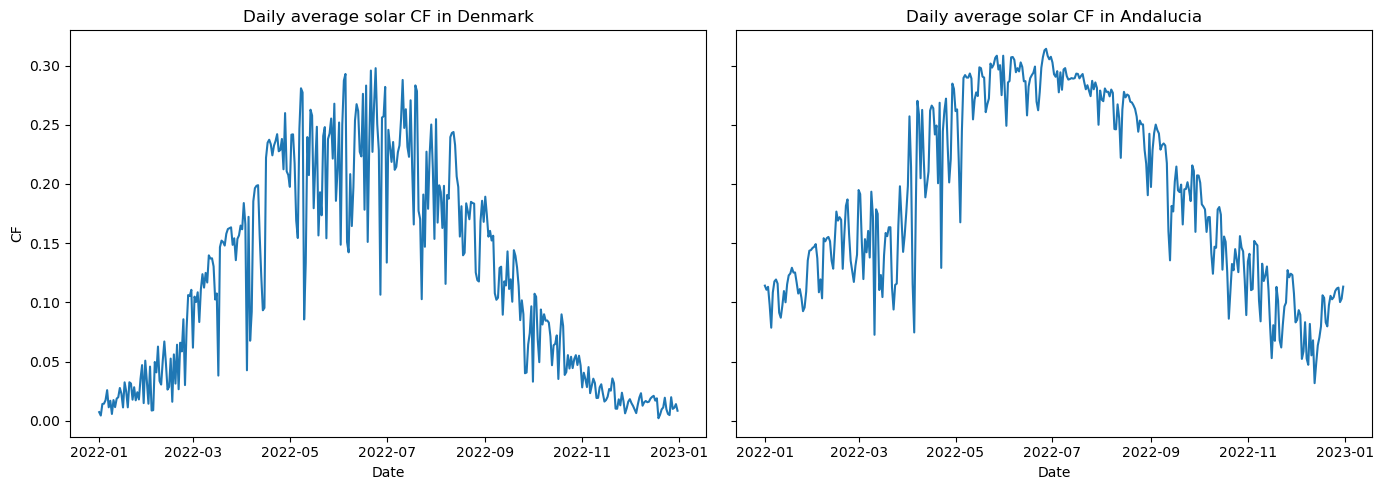

In [36]:
import xarray as xr
import matplotlib.pyplot as plt

# Regions and files
ids = ["DK0", "ES6"]
regions = {"DK0": "Denmark", "ES6": "Andalucia"} 

# Load datasets
ds = {id: xr.open_dataset(f"./data/clipped_era5/net_cdf_file_{id}.nc", engine="netcdf4") for id in ids}

# Prepare figure with subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, len(ids), figsize=(14, 5), sharey=True)

for i, id in enumerate(ids):
    # Spatial mean
    cf_mean = ds[id]['cf_pv'].mean(dim=['latitude', 'longitude'])
    
    # Daily resample
    cf_daily = cf_mean.resample(valid_time="1D").mean()
    
    # Plot on corresponding subplot
    axes[i].plot(cf_daily['valid_time'], cf_daily)
    axes[i].set_title(f"Daily average solar CF in {regions[id]}")
    axes[i].set_xlabel("Date")
    if i == 0:
        axes[i].set_ylabel("CF")  # Only label y-axis once

# Improve layout
plt.tight_layout()
plt.show()


In [37]:
ds1['cf_pv'].mean(dim=['latitude','longitude', 'valid_time'])

<xarray.DataArray 'cf_pv' ()> Size: 4B
array(0.0945552, dtype=float32)
Coordinates:
    number   int64 8B ...
Attributes: (12/33)
    GRIB_numberOfPoints:                      44400
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_gridType:                            regular_ll
    GRIB_uvRelativeToGrid:                    0
    GRIB_NV:                                  0
    ...                                       ...
    GRIB_shortName:                           ssrd
    GRIB_units:                               J m**-2
    long_name:                                Surface short-wave (solar) radi...
    units:                                    J m**-2
    standard_name:                            surface_downwelling_shortwave_f...
    grid_mapping:                             spatial_ref

These results are not too surprising, although we find that the differences between Andalucia and Denmark are actually smaller than we expected

## Exercise 4 - Comparing solar and wind  profiles of different regions <a id="ex4"></a>

In the fourth exercise of this assignment, we want to compare the wind power and solar PV power profiles over time between the different NUTS-1 regions.

As a first step, we need to determine the average wind and solar capacity factors for every NUTS-1 region for every 3-hour timestep of the year. To do this, it is recommended to create a pandas dataframe with every timestep as the index, and the specific NUTS-1 region as a column name.

**Note:** Running this script will take long. Hence, it is highly recommended to save the dataframes you created so you can read them later from a file, without having to re-run the script.

Please provide a detailed explanation of how you approached this, the developed code as well as a summary of the created pandas data frame (number of lines, number of columns and average values per column; are these in the same range as in exercise 3?). Explain how you checked that your results are accurate.

### Step 1 - Average CF for each timestep <a id="ex4-1"> </a>

In [38]:
len(era5.valid_time)

2920

We start by creating two empty pandas dataframes, one for pv and one for wind.
The index is the valid time and the columns are the nuts ids

In [39]:
import pandas as pd

columns = list(gdf_nuts1.index)

df_pv = pd.DataFrame(index=era5.valid_time, columns=columns)
df_wind = pd.DataFrame(index=era5.valid_time, columns=columns)

They are empty to begin with but contain the right columns and timesteps:

In [40]:
df_pv.head(2)

,ES6,PT1,ES5,ES3,ES4,ES2,ITG,FRM,ITI,FRL,...,FI1,DED,PL7,PL9,PL4,PL6,SE2,SE1,FI2,SE3
2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_wind.head(2)

,ES6,PT1,ES5,ES3,ES4,ES2,ITG,FRM,ITI,FRL,...,FI1,DED,PL7,PL9,PL4,PL6,SE2,SE1,FI2,SE3
2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
for id in df_wind.columns:
    era5_clipped = xr.open_dataset(
        f"data/clipped_era5/net_cdf_file_{id}.nc", engine="netcdf4"
    )
    cf_pv_array = era5_clipped["cf_pv"].mean(dim=["latitude", "longitude"])
    cf_wind_array = era5_clipped["cf_wind"].mean(dim=["latitude", "longitude"])
    df_pv[id] = cf_pv_array
    df_wind[id] = cf_wind_array

getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute path names
getfattr: Removing leading '/' from absolute pat

We can check that the values have been populated:

In [43]:
# let's use the df_wind as an example dataframe

print("number of columns: ", len(df_wind.columns))
print("number of lines: ", len(df_wind.index))

number of columns:  111
number of lines:  2920


In [44]:
print(f"PV average values per region:")
print(df_pv.mean())
print(f"Wind average values per region:")
print(df_wind.mean())

PV average values per region:
ES6    0.191346
PT1    0.177074
ES5    0.176261
ES3    0.179827
ES4    0.176276
         ...   
PL6    0.118812
SE2    0.116393
SE1    0.110793
FI2    0.121236
SE3    0.094555
Length: 111, dtype: float32
Wind average values per region:
ES6    0.114385
PT1    0.165477
ES5    0.120804
ES3    0.095216
ES4    0.133859
         ...   
PL6    0.292709
SE2    0.320490
SE1    0.274868
FI2    0.489886
SE3    0.215485
Length: 111, dtype: float64


As a sanity check, we make check that the time-averaged means match up with what we had before. 

In [45]:
# max difference between question 3 calculation and question 2 calculation:
max(list(df_wind.mean() - gdf_nuts1["cf_wind"]))

1.1102230246251565e-16

In [46]:
max(list(df_pv.mean() - gdf_nuts1["cf_pv"]))

2.9802322387695312e-08

Hence we can be confident that our results for 4 are consistent with 3 with a maximum error of 3e-8, which is likely a floating point rounding error. 


Let's save the dfs so that to create a 'checkpoint' for our analysis



In [47]:
df_wind.to_csv("data/cf_wind.csv")
df_pv.to_csv("data/cf_pv.csv")

In [48]:
# checkpoint
import pandas as pd

df_wind = pd.read_csv("data/cf_wind.csv", index_col=0)
df_pv = pd.read_csv("data/cf_pv.csv", index_col=0)

### Step 2 <a id="ex4-2"></a>

As a second step, you will deep-dive into one specific NUTS-1 region (not located in the Netherlands and not the same one as other groups). Create a bar plot showing the average capacity factor for every month for wind turbines and PV panels for your selected region. Present the capacity factors for both technologies in one figure. You can use the dataframe created above for this exercise, for instance using the [_resample_-function.](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)  Please provide the developed code and an explanation of your figure. Do the values presented in the figure make physical/technical sense? Justify your statements.

We will choose the region ES6, in south of spain: 

Text(0.5, 1.0, 'NUTS 1 Region ES6')

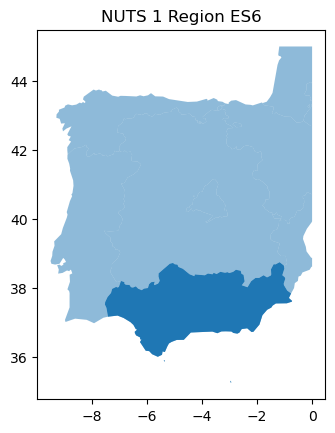

In [49]:
# insert code here

import matplotlib.pyplot as plt
from shapely.geometry import box

west = -10
south = 35
east = 0
north = 45

area = box(west, south, east, north)

smaller_area = gdf_nuts1.clip(area)

(fig, ax) = plt.subplots()

smaller_area.plot(ax=ax, alpha=0.5)
smaller_area.loc[["ES6"]].plot(ax=ax)

plt.title("NUTS 1 Region ES6")

In [50]:
# calculate monthly totals for the capacity factor:
df_wind.index = pd.to_datetime(df_wind.index)
monthly_wind = df_wind[["ES6"]].resample("1ME").mean()

monthly_wind.index.name = "month_end"

In [51]:
# calculate monthly totals for the capacity factor:
df_pv.index = pd.to_datetime(df_pv.index)
monthly_pv = df_pv[["ES6"]].resample("1ME").mean()

monthly_pv.index.name = "month_end"

In [52]:
x_axis = monthly_wind.index
x_axis

y_axis_wind = np.array(monthly_wind['ES6'])

In [53]:
y_axis_pv = np.array((monthly_pv["ES6"]))
y_axis_pv

array([0.11315327, 0.14627553, 0.14859785, 0.22448461, 0.27905752,
       0.29195345, 0.28666652, 0.25842164, 0.20474788, 0.14903844,
       0.10836517, 0.08310007])

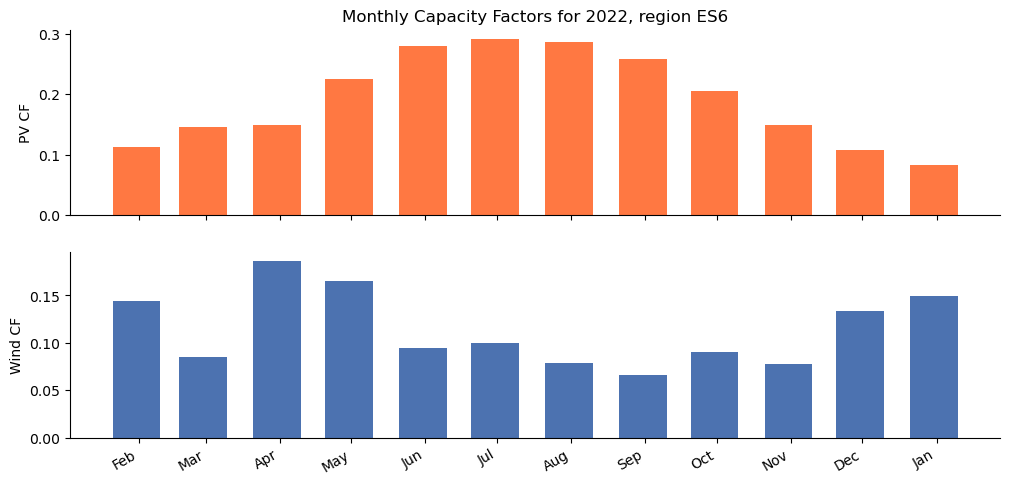

In [54]:
import matplotlib.dates as mdates 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax1.bar(x_axis, y_axis_pv, width=20, color="#FF7842")
ax1.set_ylabel("PV CF")
ax1.set_title("Monthly Capacity Factors for 2022, region ES6")

ax2.bar(x_axis, y_axis_wind, width=20, color="#4C72B0")
ax2.set_ylabel("Wind CF")

ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))


ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False) 


fig.autofmt_xdate()
plt.show()



The graph shows the complementarity of wind and solar energy for the region. 


### Step 3 <a id="ex4-3"></a>

We use Spearman's rank-correlation as opposed to Pearson as it is the preferred metric to describe correlations between capacity factors in different regions. This is because Pearson correlations are best used when the underlying relationship is expected to be linear. In our case, we do not expect a linear relationship between capacity factors in adjacent regions. Spearman has been used for similar analyses, for example in [Camargo et al](https://www.energy-proceedings.org/wp-content/uploads/icae2022/1673580926.pdf)


In [55]:
method= 'spearman'

corr = pd.DataFrame(
    {
        "wind_corr_with_ES6": df_wind.corr(method)["ES6"],
        "pv_corr_with_ES6": df_pv.corr(method)["ES6"],
    }
)
corr.loc["ES6"] = np.nan  # corr of 1 with itself is tautological - best not to plot.
corr_3_hourly = gdf_nuts1.join(corr)

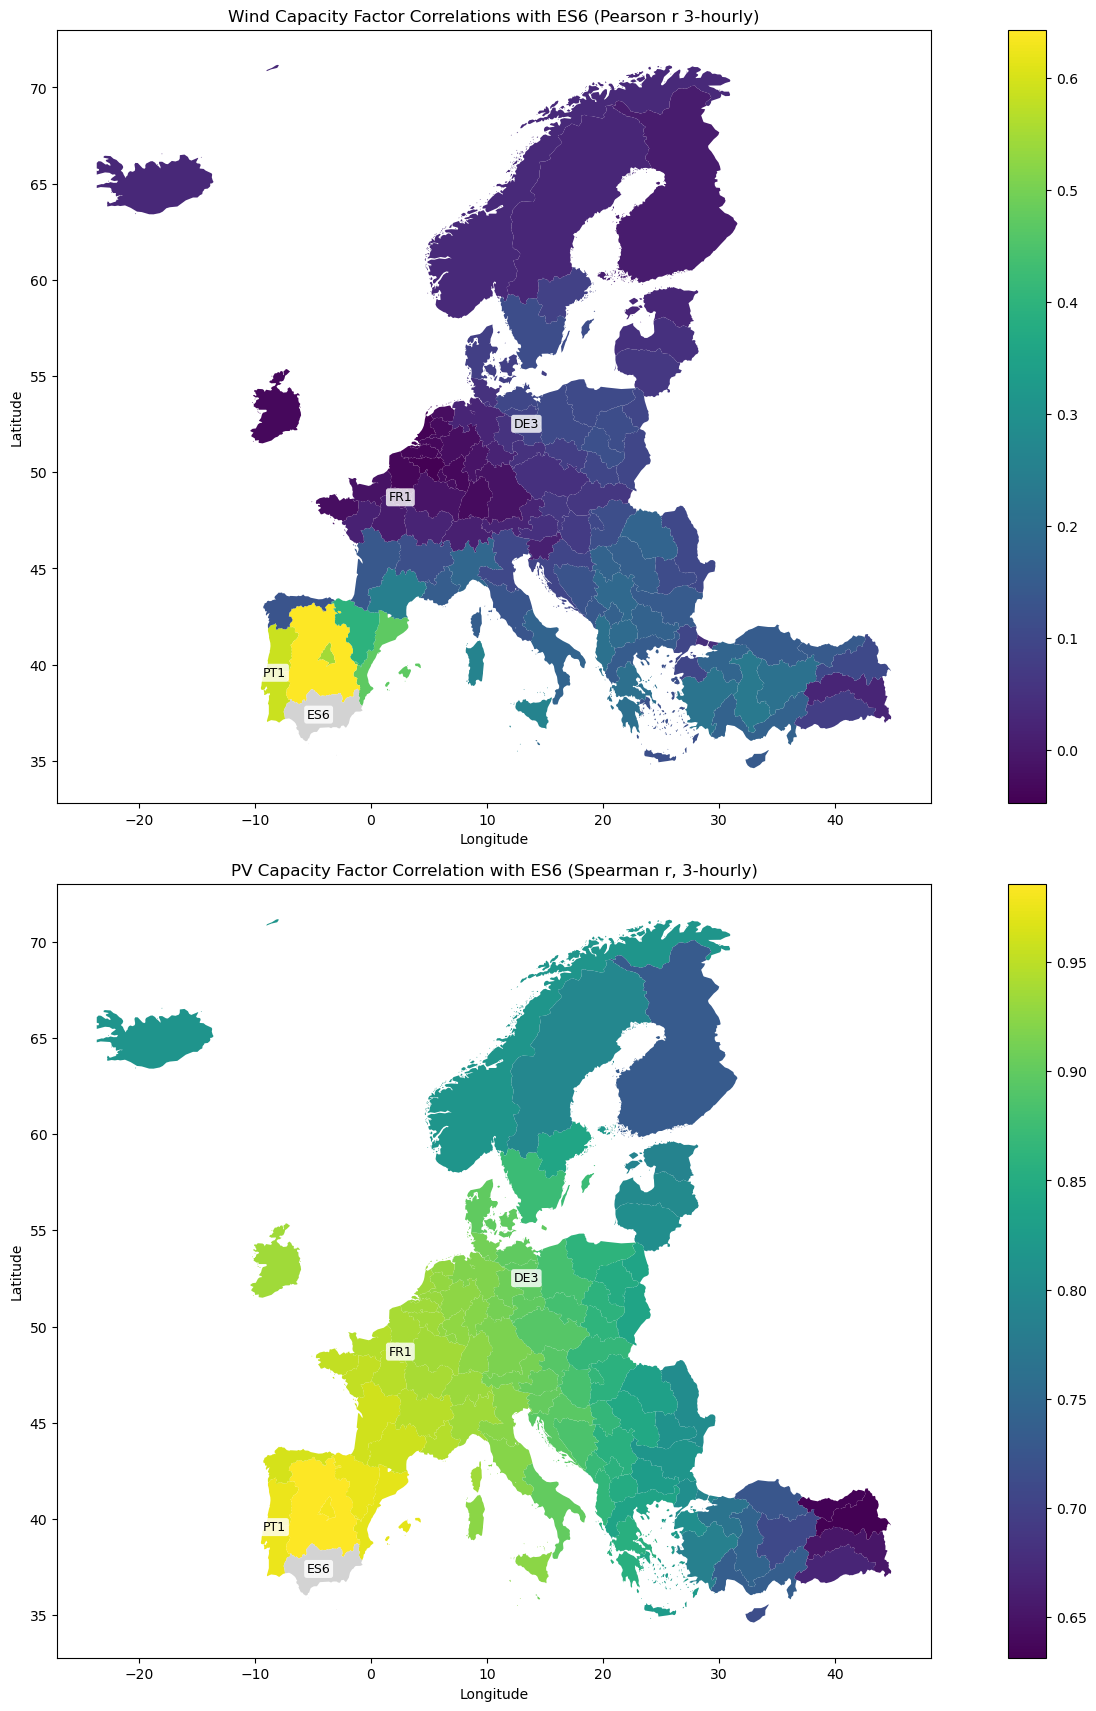

In [56]:
# Plot geo map with this correlation as a label:
# Replot:
(fig, ax) = plt.subplots(2, 1, figsize=(17, 17), constrained_layout=True)

corr_3_hourly.plot(
    ax=ax[0],
    column="wind_corr_with_ES6",
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "Reference region (ES6)"},
    linewidth=0.1,

)
ax[0].set_title(f"Wind Capacity Factor Correlations with {'ES6'} (Pearson r 3-hourly)")
corr_3_hourly.plot(
    ax=ax[1],
    column="pv_corr_with_ES6",
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "Reference region (ES6)"},
    linewidth=0.1,

)
for a in ax:
    a.set_xlabel("Longitude")
    a.set_ylabel("Latitude")
ax[1].set_title(f"PV Capacity Factor Correlation with {'ES6'} (Spearman r, 3-hourly)")
labels = ["ES6", "PT1", "FR1", "DE3"]
points = gdf_nuts1.geometry.representative_point()
for a in ax:
    for lab in labels:
        p = points.loc[lab]
        a.text(
            p.x,
            p.y,
            lab,
            fontsize=9,
            ha="center",
            va="center",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8),
        )
fig.savefig("correlations_3_hourly.png")

Q4.1. In the cell below, shortly discuss your observations based on the plots you created. What trends do you observe, and what causes these trends?

Answer 

> It appears that the solar capacity factor of ES6 is very strongly correlated with neighboring regions in Spain (Spearman r ≈ 0.85–1.0) and moderately correlated with the rest of Europe (Spearman r ≈ 0.6). Meanwhile, wind capacity factors are strongly correlated within Spain (Spearman r ≈ 0.85–0.9) and weakly correlated with the rest of Europe (r ≈ 0.0–0.1 in Northern Europe and 0.2–0.3 in the Mediterranean).

> This can be explained by the fact that solar generation is driven primarily by seasonal daylight availability, which varies little over spatial scales of ~10° latitude/longitude, whereas wind generation is driven by localized weather systems and regional topograph

Subsequently, repeat the third step using the **weekly** average values for every NUTS-1 region, instead of for the 3-hourly values. Again, plot your results for the solar PV and wind correlations between your selected NUTS-1 region and all other regions in Europe.

Please provide the developed code and the choropleth maps also in this case.

In [57]:
# insert code here
# We start again with the dataframe:
df_pv = df_pv.resample("W-MON").mean()
df_wind = df_wind.resample("W-MON").mean()

In [58]:
corr = pd.DataFrame(
    {
        "wind_corr_with_ES6": df_wind.corr(method)["ES6"],
        "pv_corr_with_ES6": df_pv.corr(method)["ES6"],
    }
)
corr.loc["ES6"] = np.nan  # corr of 1 with itself is tautological - best not to plot.
corr_weekly = gdf_nuts1.join(corr)

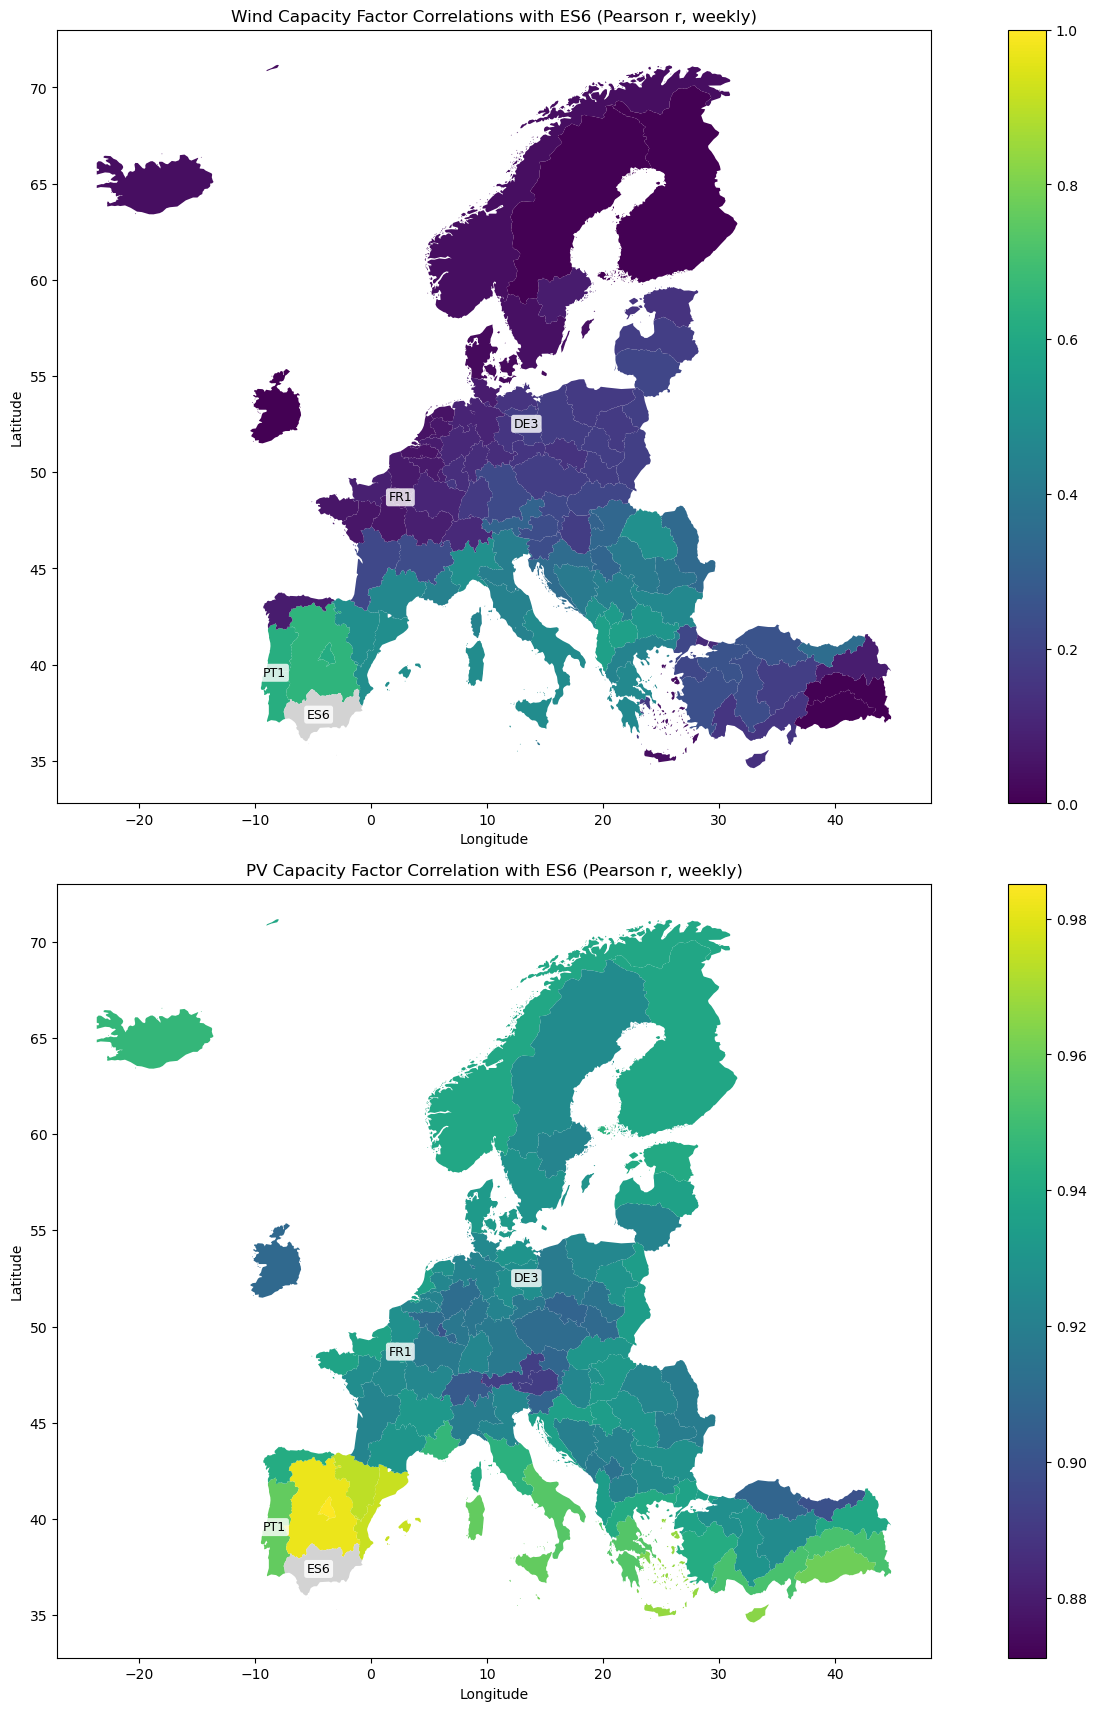

In [59]:
# Plot geo map with this correlation as a label:
# Replot:
(fig, ax) = plt.subplots(2, 1, figsize=(17, 17), constrained_layout=True)

gdf = corr_weekly 

gdf.plot(
    ax=ax[0],
    column="wind_corr_with_ES6",
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "Reference region (ES6)"},
    vmin=0,
    vmax=1,
    linewidth=0.1,

)
ax[0].set_title(f"Wind Capacity Factor Correlations with {'ES6'} (Pearson r, weekly)")
gdf.plot(
    ax=ax[1],
    column="pv_corr_with_ES6",
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "Reference region (ES6)"},
    linewidth=0.1,

)

for a in ax:
    a.set_xlabel("Longitude")
    a.set_ylabel("Latitude")
ax[1].set_title(f"PV Capacity Factor Correlation with {'ES6'} (Pearson r, weekly)")
labels = ["ES6", "PT1", "FR1", "DE3"]
points = gdf_nuts1.geometry.representative_point()

for a in ax:
    for lab in labels:
        p = points.loc[lab]
        a.text(
            p.x,
            p.y,
            lab,
            fontsize=9,
            ha="center",
            va="center",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8),
        )


fig.savefig("correlations_weekly.png")

Q4.2. What differences do you observe between the plots based on the 3-hourly values and weekly average values? Discuss the main findings, and explain what causes them.

Answer
> Both for PV and for Wind, east-west correlations are much stronger for the weekly sampling than for the 3 hourly sampling. This is because the diurnal cycle tends to reduce the correlation between regions of different longitude. This is present in the weekly cycle but not in the 3-hourly cycle. 

Q4.3. Explain why graphs showing the correlations in wind and solar energy production patterns are relevant for policy makers to provide insights into energy system design in case of high penetration of renewable energy.

> In energy systems with a high penetration of renewable generation, variability in wind and solar production creates periods of low generation relative to demand. Correlation patterns of wind and solar capacity factors help policy makers understand which regions would benefit most from being connected by high voltage grid connections. 



## Exercise 5 - Modelling RES droughts <a id="ex5"></a>

One of the main challenges for a fully-renewable based energy system is the concept of renewable energy droughts (often referred to as _Dunkelflaute_, _Dark Doldrums_ or _RES Drought_), which are moments at which there is simultaneously no or little solar **and** wind power generation. 

In this exercise, we are going to identify the share of time with a RES drought for every NUTS-1 region in mainland Europe, starting with the dataframe of the 3-hourly solar and wind generation per NUTS-1 region you created and saved earlier. 

To continue, you can assume either one of the following two simplified definitions for a period with a renewable energy drought for a specific region: 
*  Definition 1: A time period during which **both** capacity factors for wind turbines and PV panels are in the **lowest 10% quantile in the considered dataset** for the considered NUTS-1 region, _or_
*  Definition 2: A time period  during which **both** capacity factors for wind turbines and PV panels are **below 10% of their respective nominal capacity**.

Specify which definition you chose and justify your choice.

Determine the share of time with a RES drought in the considered dataset for each region for both a 3-hourly timeframe and a weekly timeframe. Plot the results.

Please provide the developed code and separate maps for the 3-hourly values and for the weekly values.

_Tip: To perform this analysis, it is recommended to create a new dataframe with every timestep as the index, and the different NUTS-1 regions as the columns. If a time period for a specific region experiences a renewable energy drought according to the definition above, mark it with 1. Otherwise, mark it with 0._

Both definitions have merits. Definition 1 specifically measures 'tail risk' in the chosen region, whereas Definition 1 measures absolute adequacy. We choose the second definition

Therefore, what counts as a wind drought in Spain should not count as a wind drought in Denmark.  

In [114]:
# reimport data 

df_wind = pd.read_csv("data/cf_wind.csv", index_col=0)
df_pv = pd.read_csv("data/cf_pv.csv", index_col=0)
for df in (df_wind, df_pv):
    df.index = pd.to_datetime(df.index)




In [115]:
def has_drought_quantile(cf_wind: pd.Series, cf_pv: pd.Series, q=0.10) -> pd.Series:
    wind_thresh = cf_wind.quantile(q)
    pv_thresh   = cf_pv.quantile(q)
    
    return (cf_wind < wind_thresh) & (cf_pv < pv_thresh)

def has_drought_definition_2(cf_wind: pd.Series, cf_pv: pd.Series) -> pd.Series:  
    return (cf_wind < 0.1) & (cf_pv < 0.1)


In [116]:
# 1. Create dictionaries to hold your series
drought_3h_dict = {}
drought_weekly_dict = {}

for region in df_wind.columns:
    # --- 3-Hourly Analysis ---
    # Result is a Series
    drought_3h_dict[region] = has_drought_quantile(df_wind[region], df_pv[region])
    
    # --- Weekly Analysis ---
    wind_weekly = df_wind[region].resample('W').mean()
    pv_weekly = df_pv[region].resample('W').mean()
    drought_weekly_dict[region] = has_drought_quantile(wind_weekly, pv_weekly)

# 2. Combine all columns at once (This is much faster and defragmented)
df_drought_3h = pd.DataFrame(drought_3h_dict)
df_drought_weekly = pd.DataFrame(drought_weekly_dict)

# Now you can calculate your shares
share_3h = df_drought_3h.mean()
share_weekly = df_drought_weekly.mean()

In [117]:
# Calculate the final "Share of Time" for each region
share_3h = df_drought_3h.mean()
share_weekly = df_drought_weekly.mean()

In [118]:
df_drought_3h

,ES6,PT1,ES5,ES3,ES4,ES2,ITG,FRM,ITI,FRL,...,FI1,DED,PL7,PL9,PL4,PL6,SE2,SE1,FI2,SE3
2022-01-01 00:00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-01-01 03:00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-01-01 06:00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-01-01 09:00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-01-01 12:00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 09:00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-12-31 12:00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-12-31 15:00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-12-31 18:00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [119]:
import matplotlib.pyplot as plt

def plot_sanity_check_shares(share_3h, share_weekly):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Sort by 3h share for a cleaner look
    share_3h_sorted = share_3h.sort_values()
    share_weekly_sorted = share_weekly.loc[share_3h_sorted.index]
    
    ax.plot(share_3h_sorted.values, label='3-Hourly Share', marker='o', linestyle='')
    ax.plot(share_weekly_sorted.values, label='Weekly Share', marker='x', linestyle='')
    
    ax.set_ylabel('Share of Time in Drought (0.0 to 1.0)')
    ax.set_xlabel('Regions (Sorted by 3h frequency)')
    ax.set_title('Sanity Check: Drought Frequency per Region')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

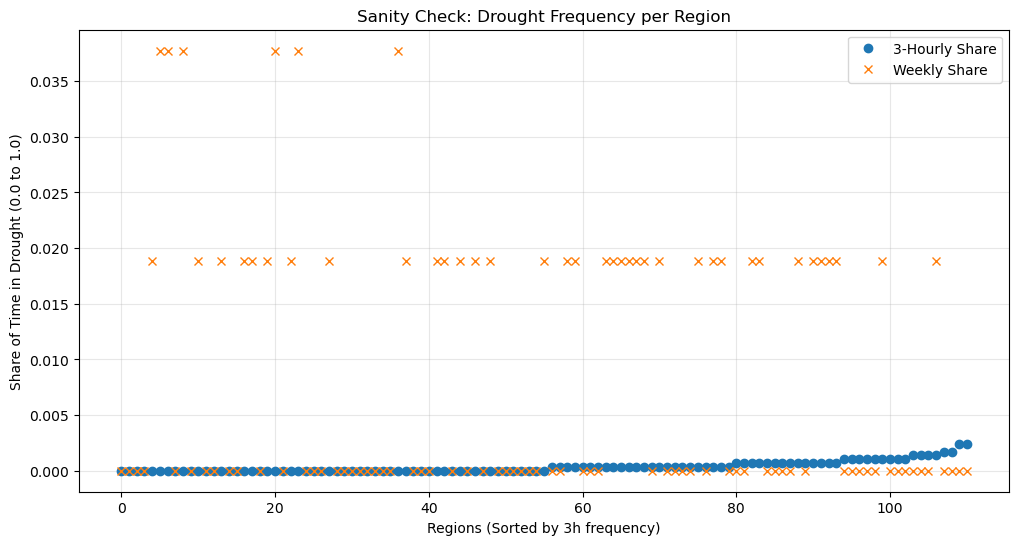

In [120]:
plot_sanity_check_shares(share_3h, share_weekly)

In [121]:
# Check for one region
region = df_wind.columns[5]

# 3-hourly thresholds
print(f"3h Wind Thresh: {df_wind[region].quantile(0.1)}")
print(f"3h Solar Thresh: {df_pv[region].quantile(0.1)}")

# Weekly thresholds
print(f"Weekly Wind Thresh: {df_wind[region].resample('W').mean().quantile(0.1)}")
print(f"Weekly Solar Thresh: {df_pv[region].resample('W').mean().quantile(0.1)}")

3h Wind Thresh: 0.00394311475453882
3h Solar Thresh: 0.0
Weekly Wind Thresh: 0.043011139077446164
Weekly Solar Thresh: 0.07449958549880953


Interestingly, weekly droughts are more common than 3 hourly droughts. This is because the weekly resampled values have higher quantiles. 

In [122]:
# we first resample the wind and pv dfs : 


df_wind = pd.read_csv("data/cf_wind.csv", index_col=0)
df_pv = pd.read_csv("data/cf_pv.csv", index_col=0)

df_wind.index = pd.to_datetime(df_wind.index)

df_pv.index = pd.to_datetime(df_wind.index)

## 

df_wind = df_wind.resample('W-MON').mean() # see offset aliases docs: https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases

df_pv = df_pv.resample('W-MON').mean() # see offset aliases docs: https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases

In [123]:

df_has_drought_weekly = has_drought_definition_2(df_wind, df_pv)

df_has_drought_weekly

drought_shares_weekly = df_has_drought_weekly.mean()

In [124]:
df_has_drought_weekly.sum().to_list() # this does not make sense, so we have to go with definition 1? 

[2,
 1,
 1,
 4,
 2,
 2,
 2,
 5,
 7,
 4,
 15,
 17,
 16,
 18,
 14,
 6,
 3,
 5,
 2,
 5,
 2,
 0,
 1,
 0,
 2,
 2,
 5,
 2,
 2,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 8,
 1,
 9,
 7,
 9,
 5,
 7,
 7,
 0,
 5,
 13,
 14,
 16,
 12,
 8,
 14,
 5,
 3,
 9,
 9,
 5,
 2,
 12,
 11,
 0,
 11,
 4,
 4,
 18,
 4,
 17,
 7,
 4,
 4,
 7,
 2,
 3,
 1,
 5,
 2,
 13,
 2,
 2,
 1,
 0,
 2,
 1,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 2]

In [125]:
df = pd.DataFrame({
    "drought_weekly": drought_shares_weekly,
    "drought_3hourly": drought_shares_3_hourly
})

NameError: name 'drought_shares_3_hourly' is not defined

## 3-hourly RES droughts fractions

FileNotFoundError: [Errno 2] No such file or directory: 'img/droughts.png'

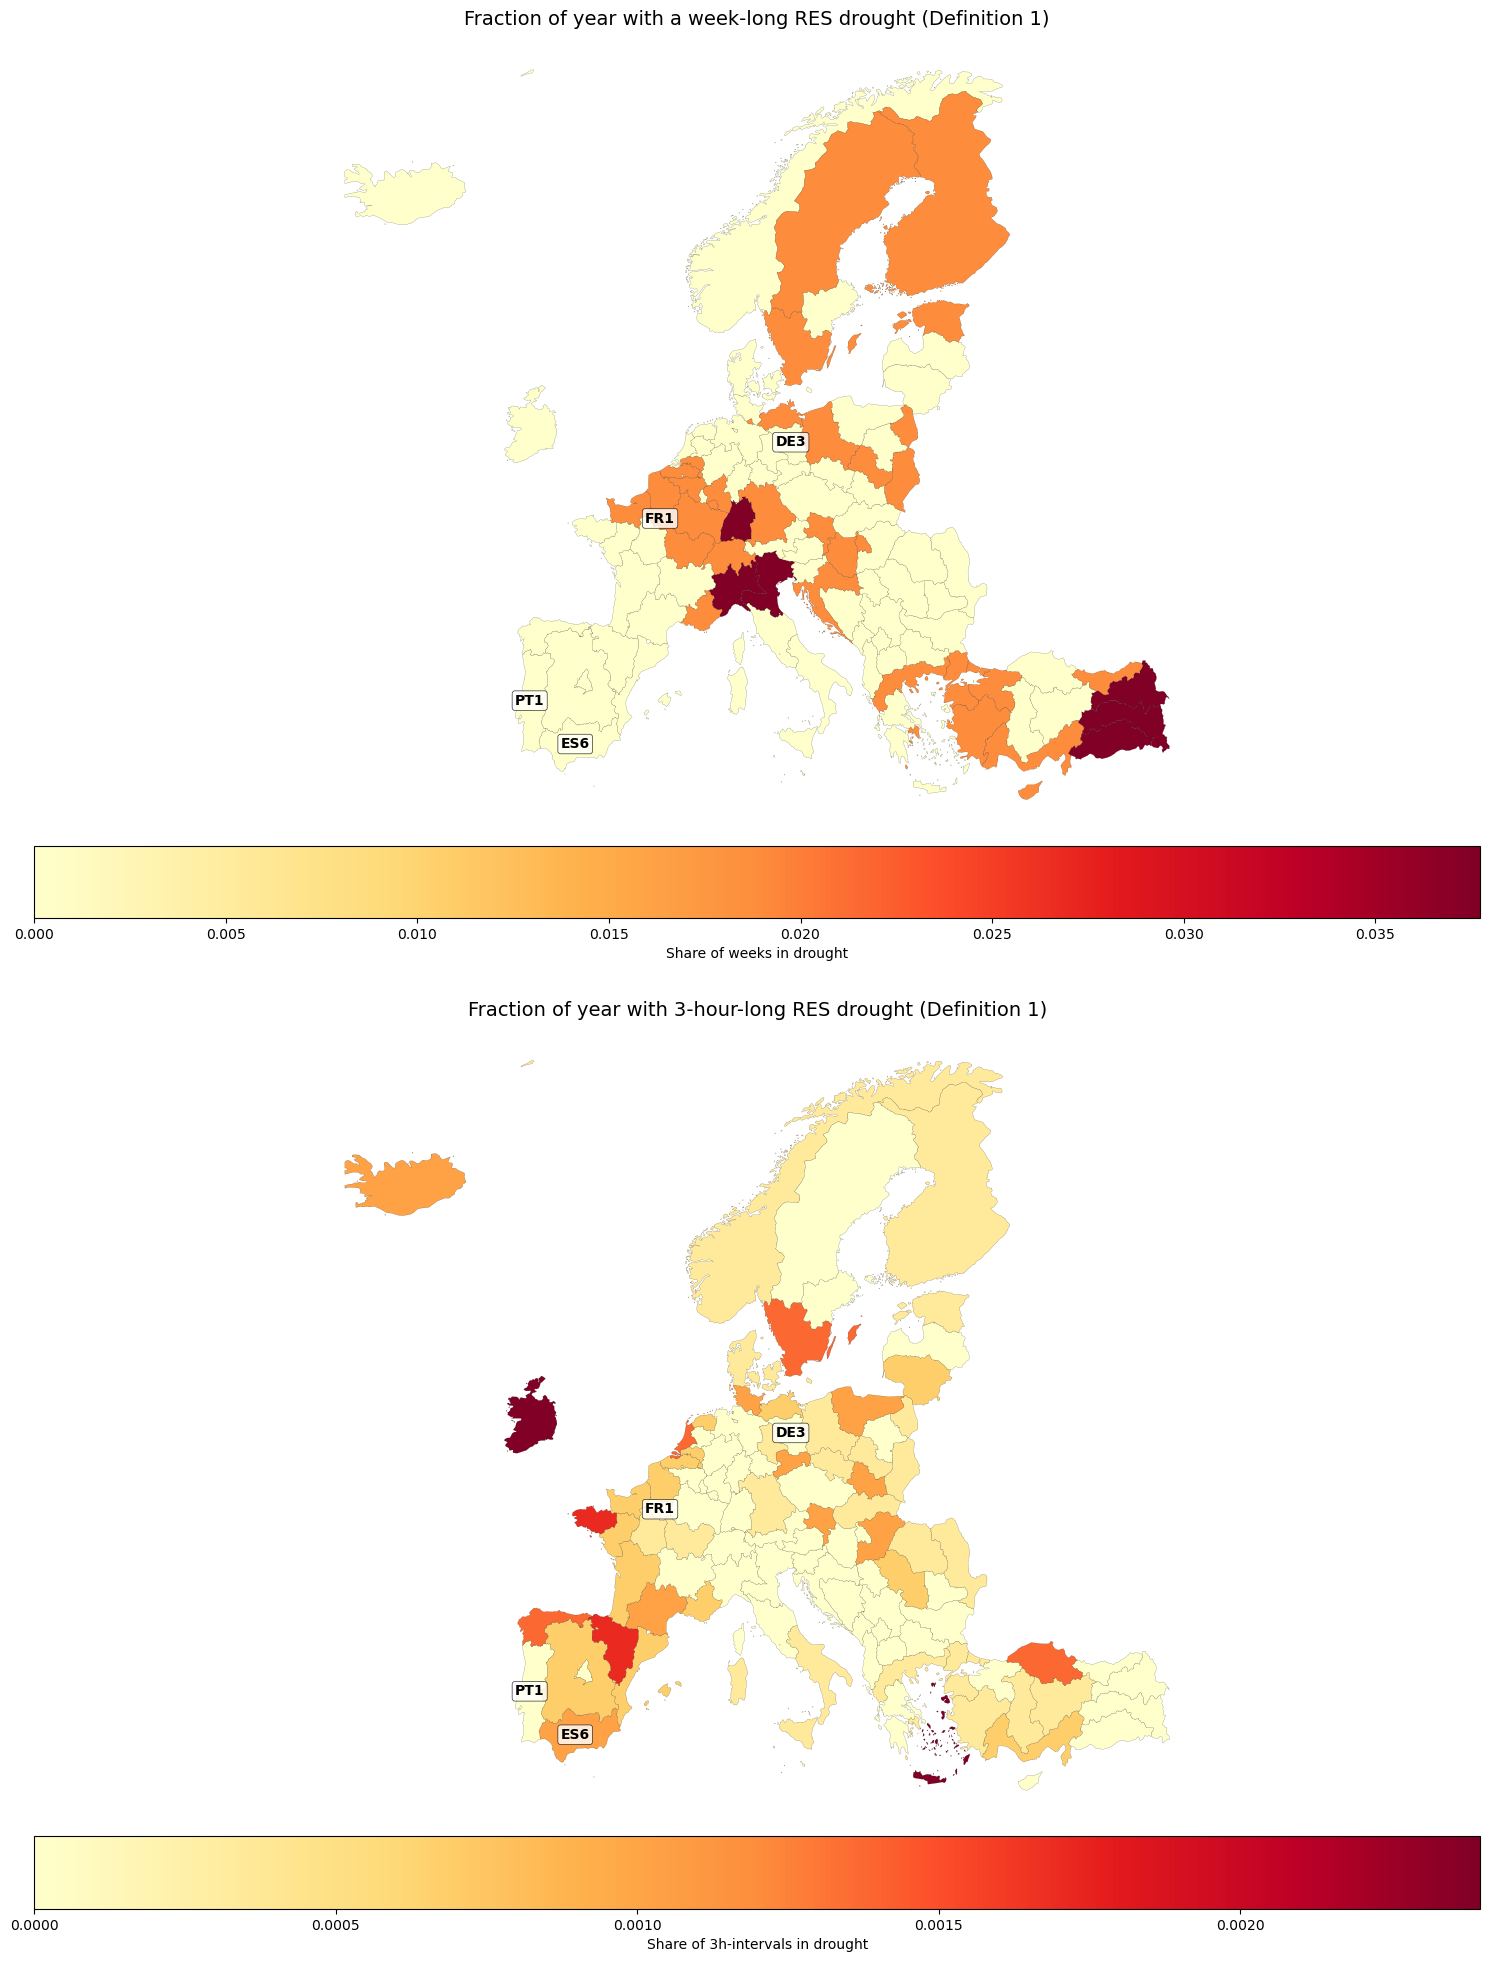

In [129]:
import matplotlib.pyplot as plt

# 1. Prepare the data for plotting
# Assuming 'gdf_nuts1' is your original GeoDataFrame with NUTS-1 indices
gdf = gdf_nuts1.copy()

# Add the calculated shares to the GeoDataFrame
# share_3h and share_weekly are the Series we created in the previous step
gdf["drought_3hourly"] = share_3h
gdf["drought_weekly"] = share_weekly

# 2. Setup the visualization
fig, ax = plt.subplots(2, 1, figsize=(15, 20)) # Increased height for better vertical maps

# Plot 1: Weekly Droughts
gdf.plot(
    ax=ax[0],
    column="drought_weekly",
    legend=True,
    legend_kwds={'label': "Share of weeks in drought", 'orientation': "horizontal", 'pad': 0.01},
    cmap="YlOrRd", # Redder colors for higher drought frequency
    missing_kwds={"color": "lightgrey", "label": "No data"},
    linewidth=0.1,
    edgecolor='black'
)
ax[0].set_title("Fraction of year with a week-long RES drought (Definition 1)", fontsize=14)

# Plot 2: 3-Hourly Droughts
gdf.plot(
    ax=ax[1],
    column="drought_3hourly",
    legend=True,
    legend_kwds={'label': "Share of 3h-intervals in drought", 'orientation': "horizontal", 'pad': 0.01},
    cmap="YlOrRd",
    missing_kwds={"color": "lightgrey"},
    linewidth=0.1,
    edgecolor='black'
)
ax[1].set_title("Fraction of year with 3-hour-long RES drought (Definition 1)", fontsize=14)

# 3. Labeling and Cleanup
labels = ["ES6", "PT1", "FR1", "DE3"]
# We use the representative_point of the gdf to ensure text is centered on the shapes
points = gdf.geometry.representative_point()

for a in ax:
    a.set_axis_off() # Removes latitude/longitude for a cleaner look
    for lab in labels:
        if lab in points.index:
            p = points.loc[lab]
            a.text(
                p.x, p.y, lab,
                fontsize=10,
                ha="center", va="center",
                fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", lw=0.5, alpha=0.8),
            )

fig.tight_layout()
fig.savefig("img/droughts.png", dpi=300)
plt.show()

Q5.1. Discuss the trends you observe in your plots. How does the difference in 3-hourly and weekly RES drought values affect the way policymakers should design their energy systems to ensure adequacy, i.e. that electricity demand can be served at all times?

Answer 
> Short (≈3-hour) and long (≈week-long) RES droughts represent fundamentally different challenges for power systems.

> A 3-hour RES drought can typically be managed using short-term flexibility such as batteries, gas peaking plants, hydro ramping, or demand response. These events do not usually threaten security of supply but increase operational stress on the system. Frequent ramping of dispatchable generators leads to higher operating costs, increased emissions, and accelerated wear and tear on assets.

> In contrast, a week-long RES drought is an energy adequacy challenge. Short-duration flexibility becomes insufficient, as batteries and reserves are energy-limited. Such events require measures that provide sustained energy supply, including:

> 1. building renewable overcapacity,

> 2. deploying long-duration or seasonal storage, and

> 3. strengthening interconnections to regions with uncorrelated weather patterns or regions with lots of reserves, such sunny deserts (although this carries geopolitical risk if those regions occur outside of the EU27

> These longer droughts are critical drivers of system design and reliability planning, particularly in high-renewables systems.





Q5.2. Critically reflect on the presented approach to identify renewable energy droughts for NUTS-1 regions. Discuss 3-5 main shortcomings of this approach, and their impact.



> 1. We are calculating the fraction of time with an renewable energy drought, but the seasonality is also very important.
> 2. Also, the distribution of drought lengths is missed (a 14 day drought in the same month is not equivalent to two 7 day droughts 4 months apart, although they are treated the same in this analysis
> 3. Coincidence with demand
> 4. 
> 5. ...

## Exercise 6 - Clustering RES droughts <a id="ex6"></a>

When designing our future renewable energy system for the whole Europe, policymakers will be interested in the similarities and differences in the RES drought patterns between regions. Neighboring regions in Europe are linked through interconnectors, which are used to transport electricity between the different regions. Hence, in case of a renewable energy drought, energy system adequacy may be ensured through the import of electricity from other regions.

In this exercise, we ask you to group the different NUTS-1 regions into a number of clusters with similar renewable energy drought patterns. This can be done by a method called _clustering_, in which the NUTS-1 regions can be subdivided into a predefined number of clusters with similar properties. You will need the dataframe with renewable energy drought data created in Exercise 5 to do this. Use the **3-hourly** values to create clusters.

Different clustering methods exist. Look up relevant clustering methods in the literature and find the documentation of a Python package supporting your preferred clustering method. Experiment with a number of clusters between 4-6 until the results are interpretable from an energy system perspective. Present your end result using a map displaying the different clusters. 

_Note: A commonly-used Python package for clustering is sklearn. Google for the appropriate documentation to conduct the analysis._

In [89]:
df_has_drought.sum()

ES6    1009
PT1     697
ES5    1085
ES3    1129
ES4     815
       ... 
PL6     406
SE2     308
SE1     403
FI2     289
SE3     486
Length: 111, dtype: int64

In [90]:
# issue: using drought boolean instead of actual cf data masks some data. wouldn't it be better to cluster according to cf patterns rather than the boolean drought/no droughts.png
Xdf = df_has_drought.astype(int).T


In [91]:
# insert code here

df_has_drought.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 2022-01-01 00:00:00 to 2022-12-31 21:00:00
Columns: 111 entries, ES6 to SE3
dtypes: bool(111)
memory usage: 339.3 KB


In [92]:
from kmodes.kmodes import KModes
import pandas as pd

# Xdf = df_has_drought.astype(int).T  (shape: 111 regions × 2920 hours)
X = Xdf.values  # kmodes works on numpy arrays

# Choose number of clusters, e.g., k=5
km = KModes(n_clusters=4, init='Huang', n_init=10, random_state=42)

labels = km.fit_predict(X)

# Attach labels to regions
cluster_assignments = pd.DataFrame({
    "region": Xdf.index,
    "cluster": labels
})

print(cluster_assignments)


    region  cluster
0      ES6        2
1      PT1        2
2      ES5        2
3      ES3        2
4      ES4        2
..     ...      ...
106    PL6        3
107    SE2        3
108    SE1        3
109    FI2        3
110    SE3        3

[111 rows x 2 columns]


In [93]:
gdf_nuts1_with_clusters = gdf_nuts1.join(cluster_assignments.set_index('region'))

Text(0.5, 1.0, 'NUTS1 Regions Clustered by Drought Patterns')

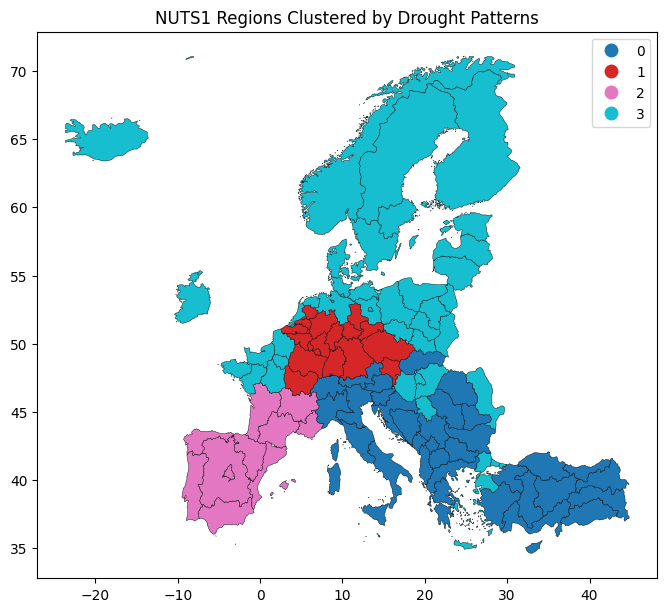

In [94]:
ax = gdf_nuts1_with_clusters.plot(
    column="cluster",
    categorical=True,
    legend=True,
    cmap="tab10",
    figsize=(8, 8),
    edgecolor="black",
    linewidth=0.3
)

ax.set_title("NUTS1 Regions Clustered by Drought Patterns")


/Users/victorelgersma/dev/DAFS/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/victorelgersma/dev/DAFS/.venv/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


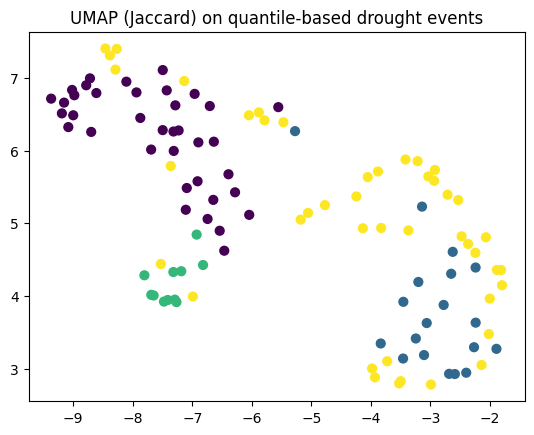

In [95]:
import umap, matplotlib.pyplot as plt

emb = umap.UMAP(metric="jaccard").fit_transform(Xdf)
plt.scatter(emb[:,0], emb[:,1], c=labels, s=40)
plt.title("UMAP (Jaccard) on quantile-based drought events")
plt.show()


In [96]:
# Xdf = drought_df.astype(int).T   # regions × time
X = Xdf.copy()
X["cluster"] = labels  # labels from k-modes or k-medoids
X_sorted = X.sort_values("cluster")


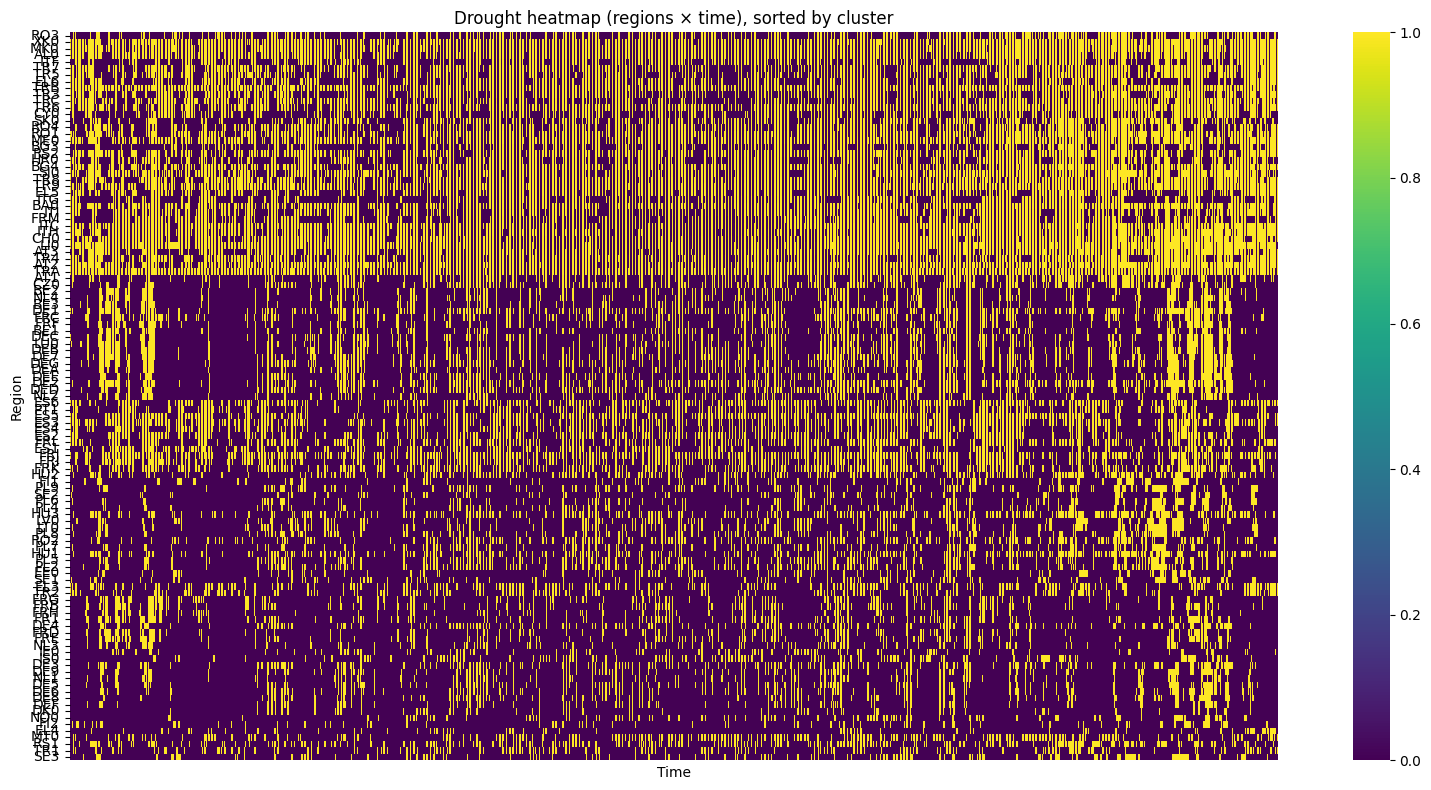

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))

sns.heatmap(
    X_sorted.drop(columns="cluster"),
    cmap="viridis",          # 0 = dark, 1 = bright
    cbar=True,
    yticklabels=X_sorted.index,
    xticklabels=False,
)

plt.title("Drought heatmap (regions × time), sorted by cluster")
plt.xlabel("Time")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


Q6.1. Shortly describe what clustering method you used, why you selected this particular clustering method and how this method works to create its clusters.

Case against k-means clustering: if region A has a drought one day earlier than region B, Euclid says they differ a lot, but climatologically they’re nearly identical.

Q6.2. What trends do you observe? Describe how policy makers could use such figures to promote an adequate European energy system design in case of high renewable energy penetration, in particular regarding investments for interconnector capacity.

In [98]:
# provide answer here

## Open Research Question

Extend the analysis on capacity factors, correlations and renewable energy droughts, for instance by eliminating some of the shortcomings you identified in Q5.2. Or propose a new energy system related question that you are interested in. Feel free to download extra data from CDS, NEWA (New European Wind Atlas) https://map.neweuropeanwindatlas.eu/, IEA (International Energy Agency) Europe Data explorer https://www.iea.org/regions/europe, or other publicly available sources to conduct your analysis. Other suggestions include electricity demand and price data from the ENTSO-e transparency platform https://transparency.entsoe.eu/, interconnection capacities from TYNDP https://tyndp.entsoe.eu/resources, installed capacities of wind energy in Europe from https://zenodo.org/records/7558885 etc. Describe the data you used, the steps you have taken for your analysis, and present your results with attractive plots. 


> Redo the cluster analysis on wind (and/or PV) capacity factors directly rather than boolean drought flags, to preserve intensity, duration, ramping, and seasonal structure that is lost under thresholding.
Why this addresses the Q5.2 shortcomings: drought flags are highly sensitive to the chosen threshold/window; clustering the raw CF (or smoothed CF) avoids “binary loss” and tends to produce more stable, interpretable regimes.

> Poposal 2) Exploring seasonality of RES droughts  - when do they occur? 

> Proposal 3) Do a separate analysis of Wind and Solar cfs / cluster analysis

> Proposal 4) Bring in electricity demand to test whether low RES aligns with high demand (riskier). ENTSO-E provides European power statistics and transparency data access paths. 
entsoe.eu. 

    
> Proposal 5) Measuring severity of droughts as well as their frequency (i.e weighing 0 production more than 0.5%?)
- Plots: “residual load” distribution per cluster; top-10 stress hours (high demand + low wind/PV).

# Ideas: 







## Download data  on 

# Sources <a id="sources"></a>


Docs:
- https://docs.xarray.dev
- https://docs.python.org/3/

What is a variable, dimension, coordinate? 
- https://www.youtube.com/watch?v=1AtfxsglBjs 

Creating a DataArray from scratch:
- https://www.youtube.com/watch?v=hiwDEjv2a60

Creating subplots:
https://www.youtube.com/watch?v=yCGfZhDzVXY

Rioxarray:
- https://www.youtube.com/watch?v=oNkgK3l4uTY

On using pd.sesample (useful for question 4)
- https://www.youtube.com/watch?v=l4dvMiSDBzs

xarray tutorial:
https://www.youtube.com/watch?v=zoB54IpofYA&list=PLTJsu1ustEMbVgE6SivbF17XvWmb3hqoR&index=1